In [1]:
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from enum import Enum
import collections
import pyfftw
import os.path
from matplotlib.colors import LogNorm

%matplotlib inline


class FIELD(Enum):      
        ELECTRIC = [1,['e_0', 'e_1', 'e_2']]
        CURRENT = [1,['jaux_0', 'jaux_1', 'jaux_2']]
        VELOCION = [1,['vi_0', 'vi_1', 'vi_2']]
        DENSELEC = [1,['ne_0','ne_1','ne_2','ne_3']]
        PRESSURE = [1,['pe_0', 'pe_1', 'pe_2','pe_3', 'pe_4', 'pe_5']]
        DENSITY = [1,['nv1_0']]
        VELOCITY = [1,['nv1_1', 'nv1_2', 'nv1_3']]
        DENSITY1 = [1,['nv2_0']]
        VELOCITY1 = [1,['nv2_1', 'nv2_2', 'nv2_3']]
        DENSITY2 = [1,['nv3_0']]
        VELOCITY2 = [1,['nv3_1', 'nv3_2', 'nv3_3']]
        MAGNETIC = [1,['b_0', 'b_1', 'b_2']]
        IPRESSURE = [1,['pi2_0', 'pi2_1', 'pi2_2','pi2_3', 'pi2_4', 'pi2_5']]
        MPOTENTIAL = [1,['pot_0', 'pot_1', 'pot_2','pot_3', 'pot_4', 'pot_5']]
        EFIELDBEAM = [1,['elas_0']]
    
def loadVarComp(filePath, fld, comp):           
        f = h5py.File(filePath)
#         print(f['vars/'].keys())
        allData = collections.defaultdict(lambda: np.ndarray(0))
        VAR0_name = 'vars/'+fld.value[1][0]
        SHAPE = f[VAR0_name].shape    
        Lx=SHAPE[0]
        Ly=SHAPE[1]
        Lz=SHAPE[2]
        data = np.zeros([Lx, Ly, Lz])
        VAR_name = 'vars/'+fld.value[1][comp]
        data[...] = f[VAR_name]
            
        f.close()
        return data 
    
    
PARTICLE_SIZE = 7
def getParticlesNumber(filePath):
    f = h5py.File(filePath,'r')
    totalParticlesNum = len(f['vars/particles'])/PARTICLE_SIZE
    f.close
    return totalParticlesNum   

def loadFullParticles(filePath, shift, number):           
        f = h5py.File(filePath,'r')        
        particles = np.zeros([int(number),PARTICLE_SIZE])
        startIdx = int(shift)*PARTICLE_SIZE
        endIdx = int(shift+number)*PARTICLE_SIZE
        allParticles = f['vars/particles'][startIdx:endIdx]
        number = int(number)
        for i in range(PARTICLE_SIZE):
            particles[0:number,i] = allParticles[i:(number*PARTICLE_SIZE+i):PARTICLE_SIZE]            
        f.close()
        return particles 

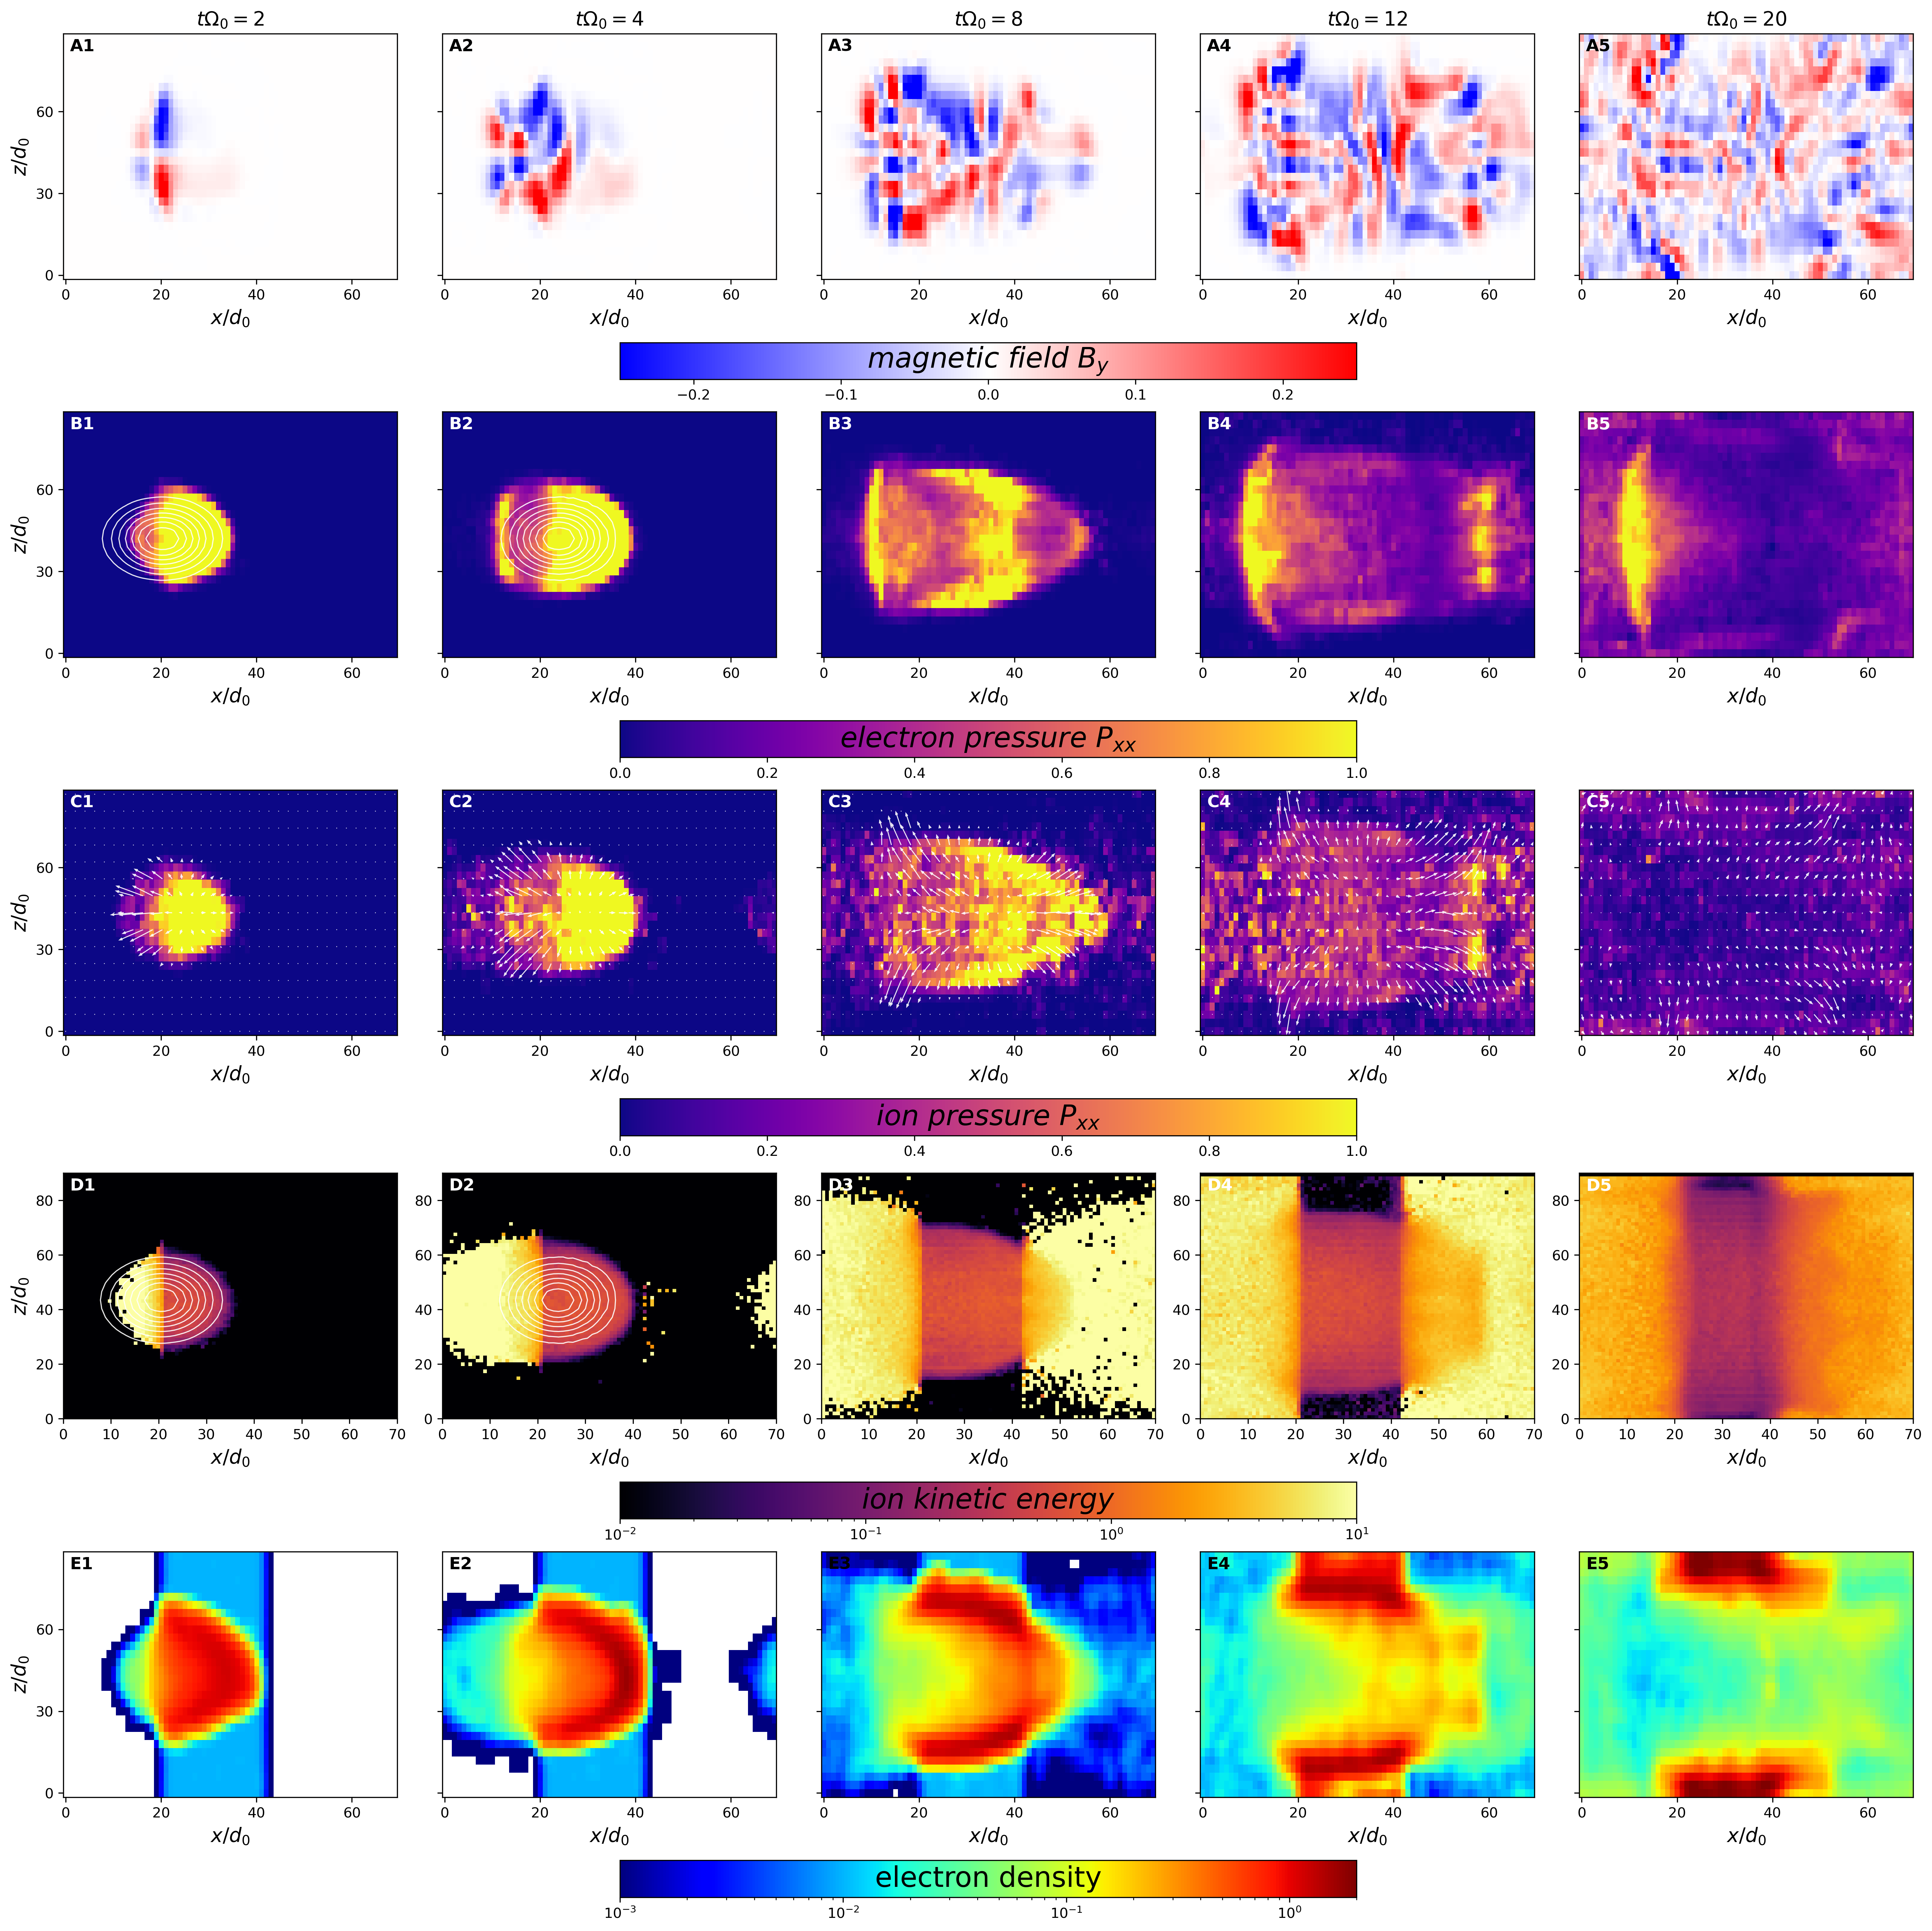

In [2]:
def plot_full_figure_with_original_energy(
        base_path,
        time_steps,
        y0, y1,
        bins=(90, 64),
        extent=[0, 64, 0, 90],
        dpi=250):

    n_cols = len(time_steps)
    n_rows = 5
    panel_labels = ["A", "B", "C", "D", "E"]


    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(3.8 * n_cols, 3.8 * n_rows),
        dpi=dpi,
        constrained_layout=True
    )


    xedges = np.linspace(extent[0], extent[1], bins[0] + 1)
    zedges = np.linspace(extent[2], extent[3], bins[1] + 1)

    for col_idx, t in enumerate(time_steps):

        B = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                        FIELD.MAGNETIC, 1)
        sl = B[..., B.shape[1] // 2, :]
        ax = axes[0, col_idx]
        im0 = ax.imshow(sl.T, vmin=-.25, vmax=.25,
                        origin='lower', aspect='auto', cmap='bwr')
        ax.set_title(f"$t\\Omega_0={int(2.*t)}$", fontsize=14)
        
        pxx_e = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                            FIELD.PRESSURE, 0)
        sl = pxx_e[..., pxx_e.shape[1] // 2, :]
        ax = axes[1, col_idx]
        im1 = ax.imshow(sl.T, vmin=0, vmax=1,
                        origin='lower', aspect='auto', cmap='plasma')

        pxx_i = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                            FIELD.IPRESSURE, 0)
        sl = pxx_i[..., pxx_i.shape[1] // 2, :]
        ax = axes[2, col_idx]
        im2 = ax.imshow(sl.T, vmin=0, vmax=1,
                        origin='lower', aspect='auto', cmap='plasma')

        vx_i = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                   FIELD.VELOCION, 0)
        vz_i = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                           FIELD.VELOCION, 2)
        
        vx_sl = vx_i[..., vx_i.shape[1] // 2, :]
        vz_sl = vz_i[..., vz_i.shape[1] // 2, :]
        
        vx_sl = vx_sl.T
        vz_sl = vz_sl.T

        step = 2

        X = np.linspace(0, vx_sl.shape[1], vx_sl.shape[1])
        Z = np.linspace(0, vx_sl.shape[0], vx_sl.shape[0])
        Xg, Zg = np.meshgrid(X, Z)
        
        Xg = Xg[::step, ::step]
        Zg = Zg[::step, ::step]
        vx_q = vx_sl[::step, ::step]
        vz_q = vz_sl[::step, ::step]
        
        axes[2, col_idx].quiver(
            Xg, Zg,
            vx_q, vz_q,
            angles='xy',
            scale_units='xy',
            color='white',
            scale=0.5,
            width=0.003,
            headwidth=3,
            headlength=4,
            alpha=0.9
        )

        ax = axes[3, col_idx]
        particles_file = os.path.join(base_path, f"test_particles_{t}.h5")

        num_particles = int(getParticlesNumber(particles_file))
        particles = loadFullParticles(particles_file, 0, num_particles)

        y = particles[:, 2]
        z = particles[:, 3]
        mask_layer = (y >= y0) & (y <= y1)
        particles_layer = particles[mask_layer]

        mask_type = (particles_layer[:, 0] == 0) | (particles_layer[:, 0] == 1)
        particles_row = particles_layer[mask_type]

        x = particles_row[:, 1]
        z = particles_row[:, 3]-1.5
        vx, vy, vz = particles_row[:, 4], particles_row[:, 5], particles_row[:, 6]
        energy = 0.5 * (vx**2 + vy**2 + vz**2)

        H, _, _ = np.histogram2d(x, z, bins=[xedges, zedges], weights=energy)
        counts, _, _ = np.histogram2d(x, z, bins=[xedges, zedges])

        with np.errstate(divide='ignore', invalid='ignore'):
            H_avg = np.where(counts > 0, H / counts, 0)

        H_avg[H_avg <= 0] = 1e-10

        im3 = ax.imshow(
            H_avg.T,
            origin='lower',
            extent=extent,
            aspect='auto',
            cmap='inferno',
            norm=LogNorm(vmin=1e-2, vmax=10)
        )

        
        ax.set_ylim([0, 90])
        
        pot = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                          FIELD.MPOTENTIAL, 0)

        pot_sl = pot[..., pot.shape[1] // 2, :]
        pot_sl = pot_sl.T

        levels = np.linspace(pot_sl.max()/5, pot_sl.max(), 8)
        if col_idx < 2:
            axes[1, col_idx].contour(
                pot_sl,
                levels=levels,
                colors='white',
                linewidths=0.8,
                alpha=0.9
            )

            ax.contour(
                pot_sl,
                levels=levels,
                extent=extent,
                colors='white',
                linewidths=0.8,
                alpha=0.9
            )

        dens = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                   FIELD.DENSELEC, 0)

        sl = dens[..., dens.shape[1] // 2, :]
        ax = axes[4, col_idx]
        
        im4 = ax.imshow(
            sl.T,
            norm=LogNorm(vmin=1e-3, vmax=2.),
            origin='lower',
            aspect='auto',
            cmap='jet'
        )

    for r in range(n_rows):
        for c in range(n_cols):
            if r == 0 or r == n_rows-1:
                axes[r, c].text(
                    0.02, 0.93, f"{panel_labels[r]}{c+1}",
                    transform=axes[r, c].transAxes,
                    fontsize=12, fontweight='bold', color="black"
                )
            else:
                axes[r, c].text(
                    0.02, 0.93, f"{panel_labels[r]}{c+1}",
                    transform=axes[r, c].transAxes,
                    fontsize=12, fontweight='bold', color="white"
                )                
                
    xticks = np.arange(0, 61, 20) 
    zticks = np.arange(0, 30, 10)
    
    for r in range(n_rows):   
        
        for c in range(n_cols):
    
            ax = axes[r, c]
            ax.set_xlabel("$x/d_0$", fontsize=14)
            if c == 0:
                ax.set_ylabel("$z/d_0$", fontsize=14)
                
            if r == 3:
                continue;
            ax.set_xticks(xticks)
            ax.set_yticks(zticks)
            ax.set_yticklabels(zticks*3)
            
            
            
            if c > 0:
                ax.set_yticklabels([])
    
    colorbars = [im0, im1, im2, im3, im4]
    labels = ["$magnetic$ $field$ $B_{y}$", "$electron$ $pressure$ $P_{xx}$", "$ion$ $pressure$ $P_{xx}$",
              "$ion$ $kinetic$ $energy$", "electron density"]
    
    for im, label, ax_row in zip(colorbars, labels, range(5)):
        cbar = fig.colorbar(im, ax=axes[ax_row, :], shrink=0.6, orientation='horizontal')
        cbar.set_label('')
        cbar.ax.text(0.5, 0.5, label, ha='center', va='center',fontsize=20, transform=cbar.ax.transAxes)

    
    plt.show()

plot_full_figure_with_original_energy(
    base_path="../output/",
    time_steps=[1,2,4,6,10],
    y0=0, y1=90,
    bins=(90, 70),
    extent=[0, 70, 0, 90],
    dpi=300
)

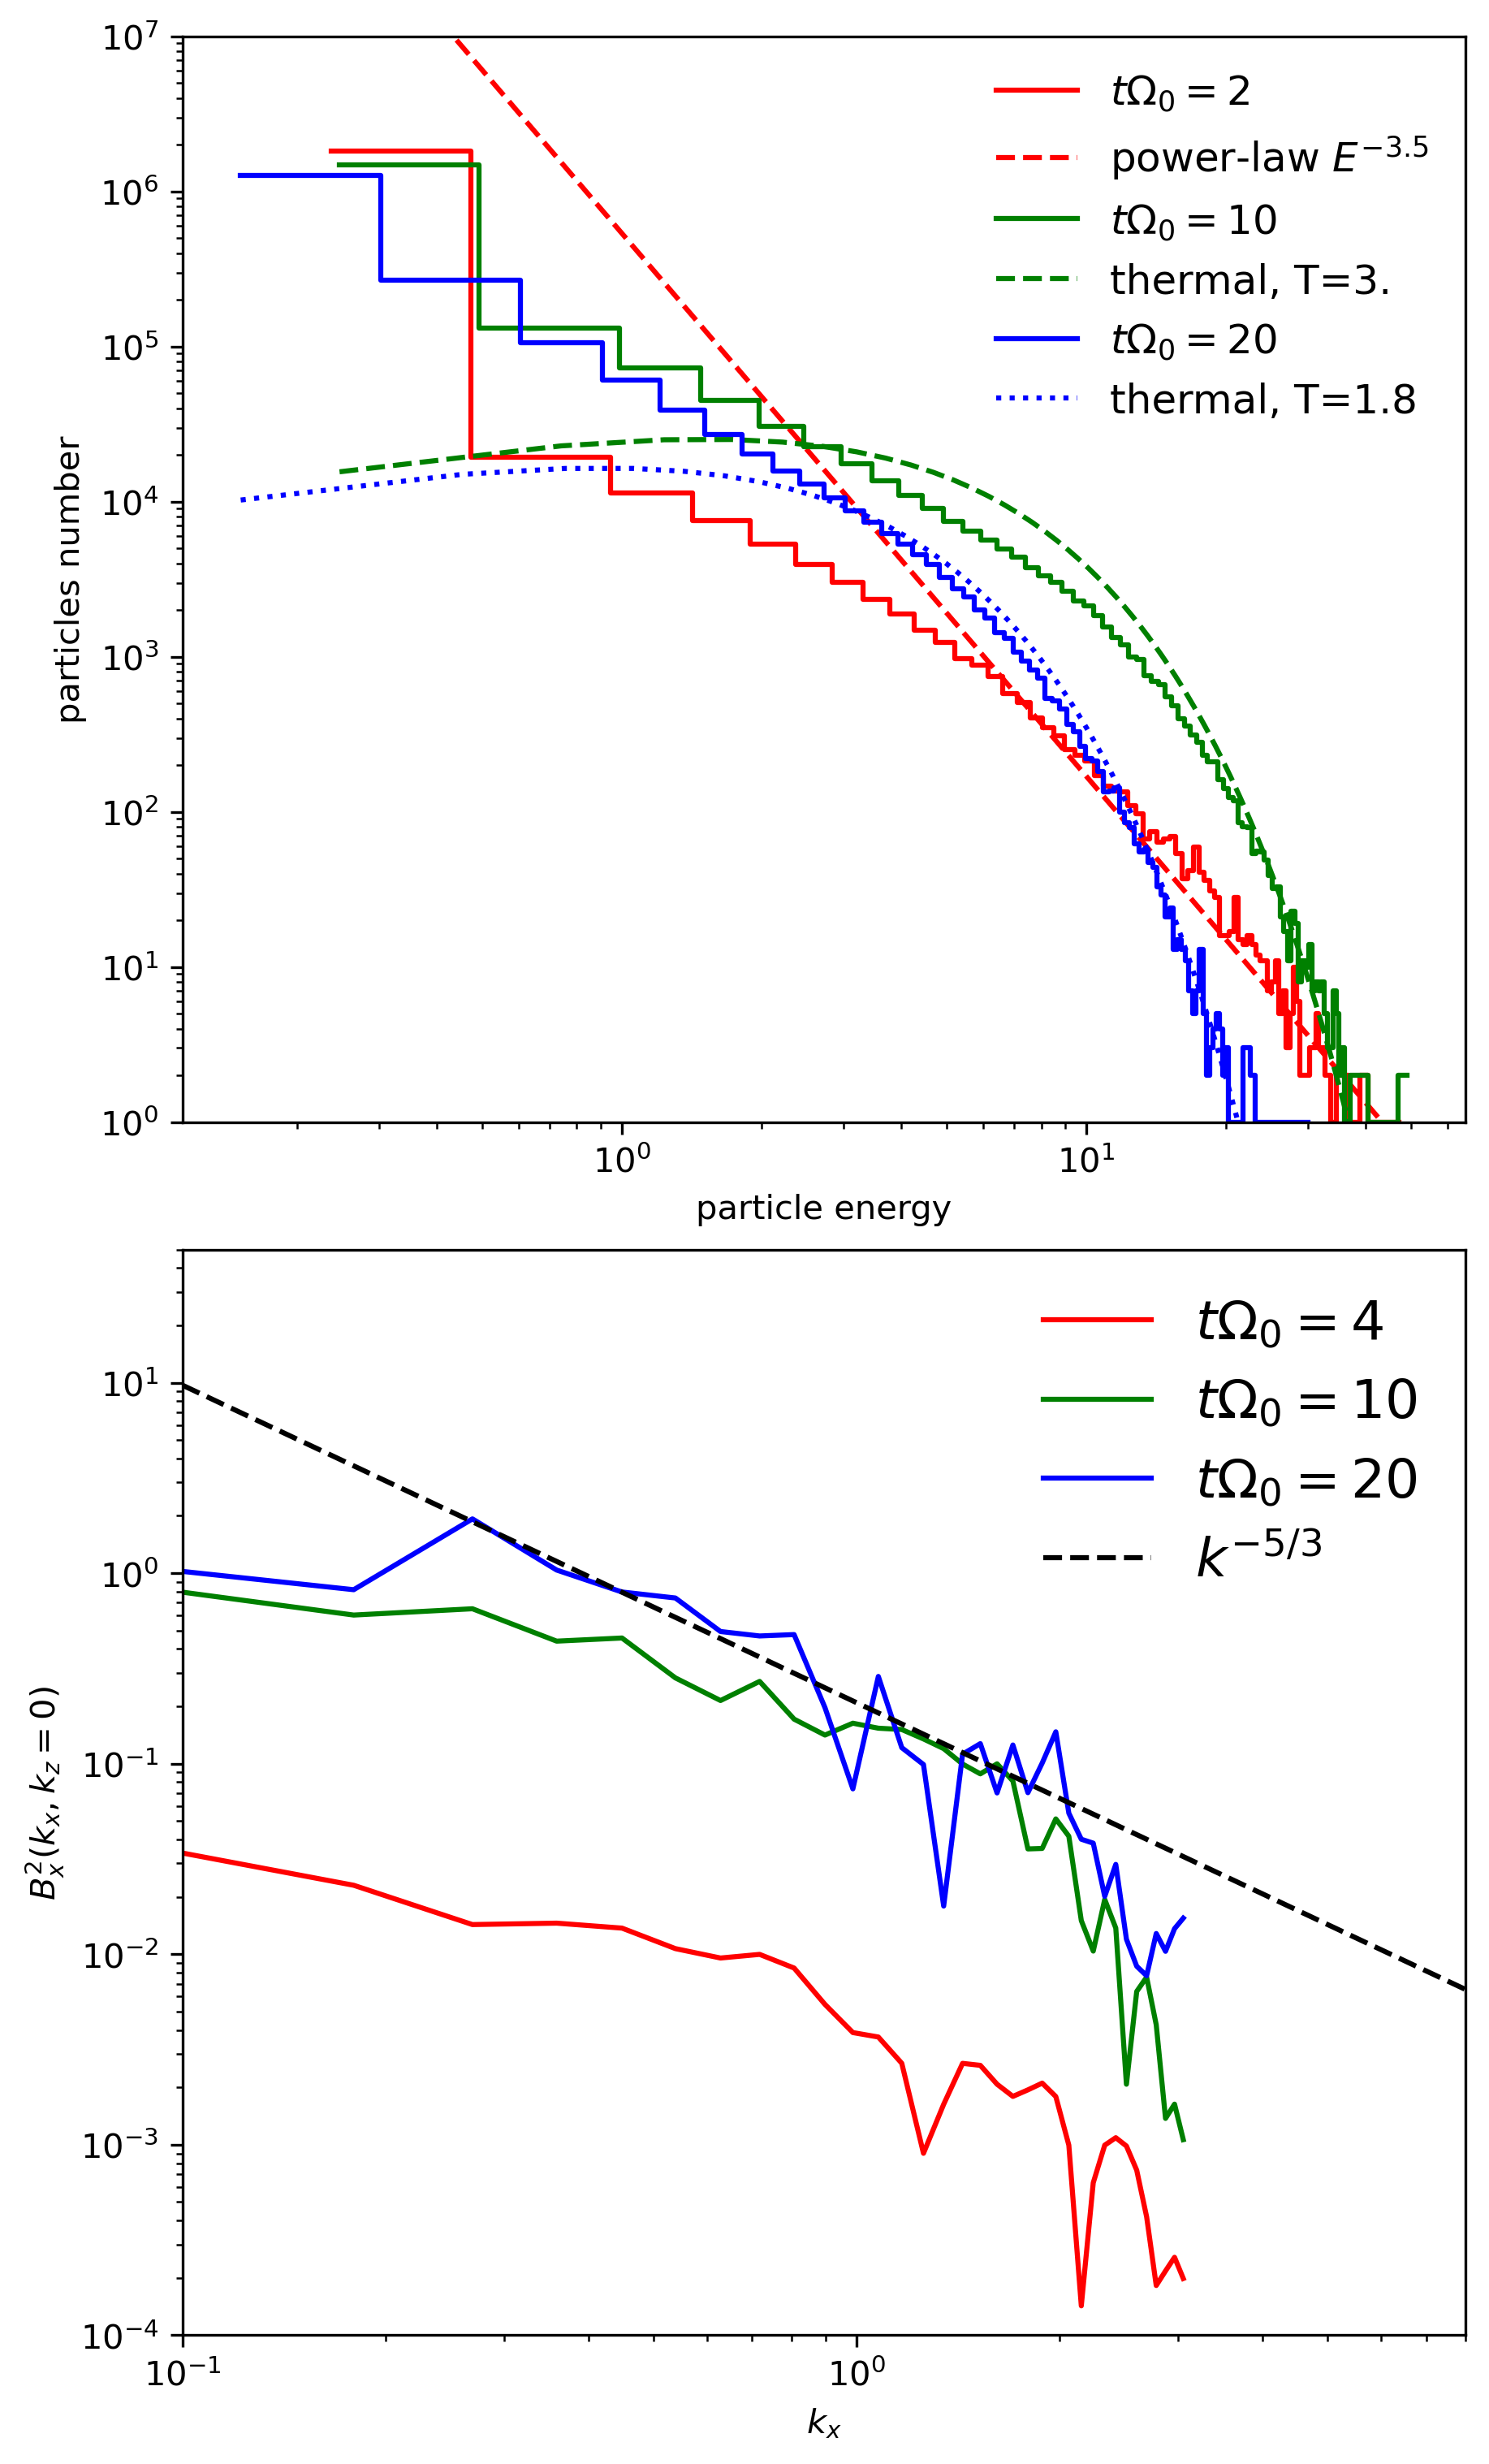

In [5]:
file1 = '../output/test_particles_1.h5'
file2 = '../output/test_particles_5.h5'
file3 = '../output/test_particles_10.h5'

base_path = '../output/'
times = [2, 5, 10]
Lx, Ly = 70.0, 90.0

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10), dpi=300, constrained_layout=True)
ax_energy, ax_fft_1d = axes

def compare_energy_distributions_from_files3_axes(file1, file2, file3,
                                                  ax,
                                                  label1='Dataset 1', label2='Dataset 2', label3='Dataset 3',
                                                  type_filter=0, bins=100, mass=1.0, normalized=False):

    def extract_energy(particles):
        mask = (particles[:, 0] == 1)
        p = particles[mask]
        if len(p) == 0:
            return None
        vx, vy, vz = p[:, 4], p[:, 5], p[:, 6]
        v_squared = vx**2 + vy**2 + vz**2
        return 0.5 * mass * v_squared

    num1 = getParticlesNumber(file1)
    num2 = getParticlesNumber(file2)
    num3 = getParticlesNumber(file3)

    p1 = loadFullParticles(file1, 0, num1)
    p2 = loadFullParticles(file2, 0, num2)
    p3 = loadFullParticles(file3, 0, num3)

    e1 = extract_energy(p1)
    e2 = extract_energy(p2)
    e3 = extract_energy(p3)

    for energy, label in zip([e1, e2, e3], [label1, label2, label3]):
        if energy is None:
            print(f"No particles matching filter in {label}")
            continue
        hist, bin_edges = np.histogram(energy, bins=bins, density=normalized)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        valid = (bin_centers > 0) & (hist > 0)

        if energy is e1:
            alpha = 3.5
            power_model = bin_centers**(-alpha)
            hist_model = hist[valid]
            scale_power = hist_model[15] / power_model[15]
            ax.plot(bin_centers[valid], hist[valid], drawstyle='steps-mid', label=label, c='r')
            ax.plot(bin_centers, power_model * scale_power, 'r--',
                    label=r'power-law $E^{-%g}$' % alpha)
        if energy is e2:
            kT = 3.
            thermal_model = (2 / np.sqrt(np.pi)) * (1 / kT**1.5) * np.sqrt(bin_centers) * np.exp(-bin_centers / kT)
            thermal_model /= np.trapz(thermal_model, bin_centers)

            hist_model = hist[valid]
            scale_thermal = hist_model[5] / thermal_model[5]
            ax.plot(bin_centers[valid], hist[valid], drawstyle='steps-mid', label=label, c='g')
            ax.plot(bin_centers, thermal_model * scale_thermal, 'g--',
                    label='thermal, T=3.')

        if energy is e3:
            hist_model = hist[valid]
            scale_power = hist_model[2] / power_model[2]
            ax.plot(bin_centers[valid], hist[valid], drawstyle='steps-mid', label=label, c='b')

            kT = 1.8
            thermal_model = (2 / np.sqrt(np.pi)) * (1 / kT**1.5) * np.sqrt(bin_centers) * np.exp(-bin_centers / kT)
            thermal_model /= np.trapz(thermal_model, bin_centers)

            hist_model = hist[valid]
            scale_thermal = hist_model[10] / thermal_model[10]
            ax.plot(bin_centers, thermal_model * scale_thermal, 'b:',
                    label='thermal, T=1.8')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('particle energy')
    ax.set_ylabel('particles number')
    ax.set_ylim(1, 1e7)
    ax.legend(fontsize=12, frameon=False)

compare_energy_distributions_from_files3_axes(file1, file2, file3, ax_energy,
                                              label1='$t\Omega_0 = 2$',
                                              label2='$t\Omega_0 = 10$',
                                              label3='$t\Omega_0 = 20$')


colors = ['r', 'g', 'b']
for i, t in enumerate(times):
    bfieldx = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                         FIELD.MAGNETIC, 0)[...,15,0:]
    bfieldy = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                         FIELD.MAGNETIC, 1)[...,15,0:]
    bfieldz = loadVarComp(os.path.join(base_path, f"test_{t}.h5"),
                         FIELD.MAGNETIC, 2)[...,15,0:]
    bfield = bfieldx*bfieldx
    Nx, Ny = bfield.shape

    kx = np.fft.fftshift(np.fft.fftfreq(Nx, d=Lx/Nx)) * 2*np.pi
    ky = np.fft.fftshift(np.fft.fftfreq(Ny, d=Ly/Ny)) * 2*np.pi

    bfield_fft = np.fft.fftshift(np.fft.fft2(bfield))
    bfield_fft_magnitude = np.abs(bfield_fft)

    ky_index = np.where(ky == 0)[0][0]
    bfield_fft_magnitude_ky0 = bfield_fft_magnitude[:, ky_index]

    ax_fft_1d.loglog(kx[kx > 0], bfield_fft_magnitude_ky0[kx > 0],
                     label=fr"$t\Omega_0 = {int(t*2)}$", color=colors[i])

kx_positive = np.linspace(0.1, 10, 100)
scale = bfield_fft_magnitude_ky0.max() * 0.05
ax_fft_1d.loglog(kx_positive, scale * kx_positive**(-5/3),
                 linestyle='--', color='k',
                 label=r"$k^{-5/3}$")

ax_fft_1d.set_xlim(0.1, 8)
ax_fft_1d.set_xlabel(r"$k_x$")
ax_fft_1d.set_ylabel(r"$B^2_x(k_x, k_z=0)$")
ax_fft_1d.set_ylim([1e-4,50])
ax_fft_1d.legend(fontsize=16, frameon=False)

plt.show()
